In [ ]:
# ML_in_Finance-Deep-Factor-Models
# Author: Matthew Dixon
# Version: 1.0 (24.7.2019)
# License: MIT
# Email: matthew.dixon@iit.edu
# Notes: tested on Mac OS X with Python 3.6 and Tensorflow 1.3.0
# Citation: Please cite the following reference if this notebook is used for research purposes:
# Bilokon P., Dixon M.F. and I. Halperin, Machine Learning in Finance: From Theory to Practice, Springer Graduate textbook Series, 2020. 

##### Description

In [1]:
import csv
import pandas as pd
import numpy as np
import re
import math
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1,l2
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from utilities import *
from view import *
import statsmodels.api as sm
import datetime as dt
from dateutil.relativedelta import *

# comment these if running python instead of ipython
%load_ext autoreload
%matplotlib inline 
%autoreload 1

Using TensorFlow backend.


In [2]:
# define neural network model in Keras
def NN(n_inputs, n_units = 10, dropout =0.1, l1_reg =0.001, activation='relu', L=2):
    # L>0 is the number of hidden layers
    
    model = Sequential()
    model.add(Dense(units=n_units, input_dim=n_inputs, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
    model.add(Dropout(dropout))
    for i in range (0,L-1):
        model.add(Dense(units=n_units, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal')) 
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
    return(model)

In [3]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

In [4]:
"""
 NN parameter tuning:
"""
def parameter_tuning(X, y, cv=3, n_epoches=100, n_batch=10, seed = 7):


   param_grid = dict(n_inputs=[X.shape[1]],n_units=[10,20,50], l1_reg = [0, 0.0001, 0.001], activation=['relu','tanh']) # dropout=[0, 0.1, 0.2, 0.3],  #n_hidden_neurons=[10,50,100], 
   estimator = KerasRegressor(build_fn=NN, epochs=n_epoches, batch_size=n_batch, verbose=0)   
   grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv,fit_params=dict(callbacks=[es]))
   grid_result = grid.fit(X, y)
 
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   means = grid_result.cv_results_['mean_test_score']
   stds = grid_result.cv_results_['std_test_score']
   params = grid_result.cv_results_['params']
   for mean, stdev, param in zip(means, stds, params):
         print("%f (%f) with: %r" % (mean, stdev, param))

In [1]:
def training(X, Y, training_dates, L, tune=False):
 
    n_epoches = 100  # maximum number of epoches (to be used with early stopping)
    n_batch = 10     # mini-batch size
    drop_out = 0.0   # level of dropout (set between 0 and 1)
    n_units = 10
    l1_reg = 0.001   # L_1 regularization parameter
    activation='tanh'
    models = {}
    xs = {}
    ys = {}
    
    models = {}
    models['linear']=[]
    models['NN']=[]
    xs = {}
    ys = {}

    xs['train']=[]
    xs['test']=[]
    ys['train']=[]
    ys['test']=[]
    
    betas = {}
    betas['NN'] =[]
    betas['linear'] =[]

    i=0
    for date in training_dates:
         start_time = timeit.default_timer()  
         print(i, date)
         train_index = X[X['date']==date].index
         
         if len(train_index)==0:
          next
         date_next=pd.Timestamp(np.datetime64(date)).to_pydatetime() + relativedelta(months=+1)
         date_next = date_next.strftime('%Y-%m-%d')
         test_index  = X[X['date']==date_next].index
         if len(test_index)==0:
          next
         

         x_train = X.loc[train_index]
         x_train=x_train.drop("date", axis=1)
         y_train = Y.loc[train_index]
         y_train= y_train.drop("date", axis=1)
         x_test  = X.loc[test_index]
         x_test=x_test.drop("date", axis=1)
         y_test =  Y.loc[test_index]
         y_test=y_test.drop("date", axis=1)
         

         n_inputs = x_train.shape[1]
         if n_inputs ==0:
          next
        
         if tune: # just perform parameter tuning once
          print("Parameter tuning with X-validation...")      
          parameter_tuning(x_train, y_train, 3)
          tune=False

         model = NN(n_units=n_units, n_inputs=n_inputs, dropout=drop_out, l1_reg=l1_reg, activation=activation, L=L)
         model.fit(x_train.values, y_train.values, epochs=n_epoches, batch_size=n_batch, verbose=0, callbacks=[es])   
         beta=sensitivities(model, x_train.values, L, activation)   
         models['NN'].append(model)
         betas['NN'].append(beta)
         x=sm.add_constant(x_train)
         model =sm.OLS(y_train, x).fit()   
         betas['linear'].append(model.params)
         models['linear'].append(model)
         xs['train'].append(x_train)
         xs['test'].append(x_test)
         ys['train'].append(y_train)
         ys['test'].append(y_test)

         elapsed = timeit.default_timer() - start_time
         print("Elapsed time:" + str(elapsed) + " (s)")
         i+=1
        
    return models, betas, xs, ys

In [9]:
# Assume that the activation function is tanh
def sensitivities(lm, X, L, activation='tanh'):
    
    W=lm.get_weights()
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    beta=np.array([0]*M*(p+1), dtype='float32').reshape(M,p+1)
    B_0 =W[1]
    for i in range (0,L):
      if activation=='tanh':  
        B_0 = (np.dot(np.transpose(W[2*(i+1)]),np.tanh(B_0))+W[2*(i+1)+1])
      elif activation=='relu':
        B_0 = (np.dot(np.transpose(W[2*(i+1)]),np.maximum(B_0,0))+W[2*(i+1)+1])
    
          
    beta[:,0]= B_0 # intercept \beta_0= F_{W,b}(0)
    for i in range(M):
      I1 = np.dot(np.transpose(W[0]),np.transpose(X[i,])) + W[1]
      if activation=='tanh':
          Z= np.tanh(I1)  
          D = np.diag(1-Z**2)
      elif activation=='relu':
          Z=np.maximum(I1,0)
          D = np.diag(np.sign(Z)) 
               
      for j in range(p):
        J = np.dot(D,W[0][j])       
        for a in range (1,L):
          I= np.dot(np.transpose(W[2*a]),Z) + W[2*a+1] 
          if activation=='tanh':  
              Z = np.tanh(I)
              D = np.diag(1-Z**2)
          elif activation=='relu':    
              Z=np.maximum(I,0)
              D = np.diag(np.sign(Z)) 
          J = np.dot(np.dot(D,np.transpose(W[a*2])),J)
        beta[i,j+1]=np.dot(np.transpose(W[2*L]),J)
            
    return(beta)

In [10]:
# Load the data
X=pd.read_csv('../X_small.csv')
Y=pd.read_csv('../Y_small.csv')

## Training of models 

In [11]:
training_periods = 100
L=2 
dates = np.unique(X['date'])[0:training_periods] 
models, betas, xs, ys = training(X,Y,dates,L,False) # set last argument to True to perform cross-validation for parameter tuning

0 2008-02-01
Epoch 00014: early stopping
Elapsed time:0.857045584009029 (s)
1 2008-03-01
Epoch 00011: early stopping
Elapsed time:0.8297597609926015 (s)
2 2008-04-01
Epoch 00012: early stopping
Elapsed time:0.9309474239998963 (s)
3 2008-05-01
Epoch 00012: early stopping
Elapsed time:0.9000957919924986 (s)
4 2008-06-01
Epoch 00014: early stopping
Elapsed time:0.9831864420266356 (s)
5 2008-07-01
Epoch 00015: early stopping
Elapsed time:1.103105993999634 (s)
6 2008-08-01
Epoch 00012: early stopping
Elapsed time:1.076695080002537 (s)
7 2008-09-01
Epoch 00011: early stopping
Elapsed time:1.0994528459850699 (s)
8 2008-10-01
Epoch 00016: early stopping
Elapsed time:1.3564357779978309 (s)
9 2008-11-01
Epoch 00014: early stopping
Elapsed time:1.2740993390034419 (s)
10 2008-12-01
Epoch 00014: early stopping
Elapsed time:1.2309099519916344 (s)
11 2009-01-01
Epoch 00056: early stopping
Elapsed time:2.145581584016327 (s)
12 2009-02-01
Epoch 00017: early stopping
Elapsed time:1.404007981007453 (s)
1

# Performance evaluation

In [12]:
# Evaluate MSE of OLS out-of-sample
MSE = 0
y_hat_linear = []
MSE_array_linear=np.array([0]*training_periods,dtype='float64')
for i in range(training_periods):
    x= sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    MSE_test_linear= mean_squared_error(y_hat_linear[-1], ys['test'][i].values)
    #print(i,MSE_test_linear)
    MSE_array_linear[i]=MSE_test_linear
    MSE+=MSE_test_linear
print("MSE:" + str(MSE/training_periods))    

MSE:0.017511483871247034


In [13]:
# Evaluate MSE of OLS in-sample
MSE = 0
MSE_array_linear_in=np.array([0]*training_periods,dtype='float64')
y_hat_linear_is =[]
for i in range(training_periods):
    x= sm.add_constant(xs['train'][i].values)
    y_hat_linear_is.append(models['linear'][i].predict(x))
    MSE_test_linear= mean_squared_error(y_hat_linear_is[-1], ys['train'][i].values)
    #print(i,MSE_test_linear)
    MSE_array_linear_in[i]=MSE_test_linear
    MSE+=MSE_test_linear
print("MSE:" + str(MSE/training_periods))    

MSE:0.004573922402548681


In [14]:
# Evaluate MSE of NN out-of-sample
MSE =0
MSE_array_NN=np.array([0]*training_periods, dtype='float64')
y_hat_NN=[]
for i in range(training_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    MSE_test_NN= mean_squared_error(y_hat_NN[-1], ys['test'][i].values)
    #print(i,MSE_test_NN)
    MSE_array_NN[i]=MSE_test_NN
    MSE+=MSE_test_NN
print("MSE:" + str(MSE/training_periods))  

MSE:0.016791142741349407


In [15]:
# Evaluate MSE of NN in-sample
MSE =0
MSE_array_NN_in=np.array([0]*training_periods, dtype='float64')
y_hat_NN_is =[]
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    MSE_test_NN= mean_squared_error(y_hat_NN_is[-1], ys['train'][i].values)
    #print(i,MSE_test_NN)
    MSE_array_NN_in[i]=MSE_test_NN
    MSE+=MSE_test_NN
print("MSE:" + str(MSE/training_periods)) 

MSE:0.005180544359044243


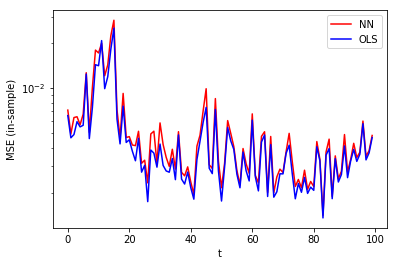

In [16]:
plt.plot(MSE_array_NN_in, color='red', label='NN')
plt.yscale('log')
plt.plot(MSE_array_linear_in, color='blue', label='OLS')
plt.ylabel('MSE (in-sample)')
plt.xlabel('t')
plt.legend()

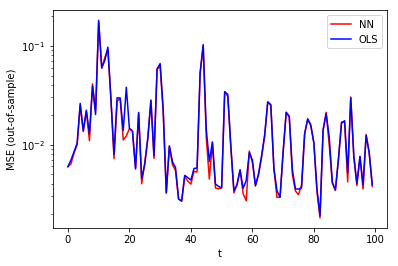

In [17]:
plt.plot(MSE_array_NN, color='red', label='NN')
plt.yscale('log')
plt.plot(MSE_array_linear, color='blue', label='OLS')
plt.ylabel('MSE (out-of-sample)')
plt.xlabel('t')
plt.legend()

# Sensitivities

In [20]:
betas['NN'][i][0][1:]

array([ 1.1427927e-09, -1.4447089e-10, -2.1118722e-10, -3.7252854e-11,
       -3.4922185e-10,  1.0481044e-09], dtype=float32)

In [21]:
n_var=np.shape(betas['NN'][1])[1]-1
print(n_var)
mu = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods,n_var)
sd = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods,n_var)
mu_ols = np.array([0]*training_periods*n_var, dtype='float32').reshape(training_periods,n_var)

for i in range(training_periods):
 mu[i,:]=np.median(betas['NN'][i], axis=0)[1:]
 sd[i,:]=np.std(betas['NN'][i],axis=0) [1:]
 mu_ols[i,:]=betas['linear'][i][1:]

6


In [22]:
names = ['EV', 'P/B', 'EV/T12M EBITDA', 'P/S' , 'P/E','Log CAP']

Text(0.5,0,'Factor')

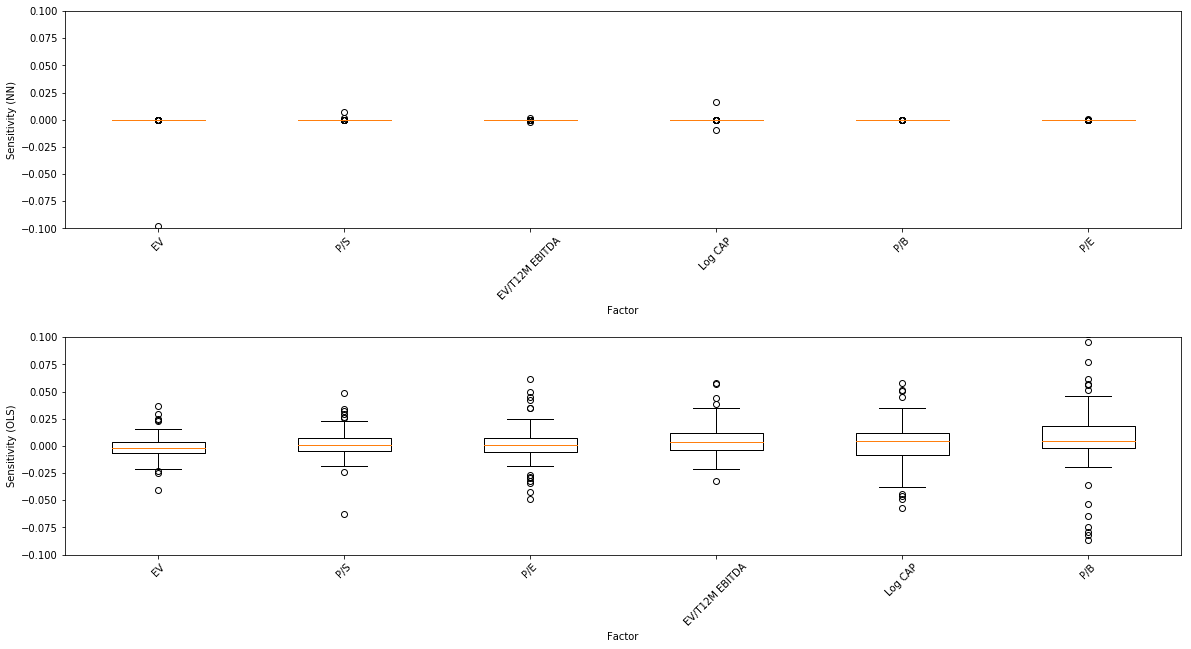

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
fig.subplots_adjust(hspace=.5)
fig.subplots_adjust(wspace=.7)
%sc=10000
idx=np.argsort(np.median(mu[:,0:n_var], axis=0))
axes[0].boxplot(mu[:,idx])       # make your boxplot
axes[0].set_xticklabels(np.array(names)[idx],rotation=45)  
axes[0].set_ylim([-0.1,0.1])
axes[0].set_ylabel('Sensitivity (NN)')
axes[0].set_xlabel('Factor')
idx=np.argsort(np.median(mu_ols[:,0:n_var], axis=0))
axes[1].boxplot(mu_ols[:,idx]) 
axes[1].set_ylim([-0.1,0.1])
axes[1].set_xticklabels(np.array(names)[idx],rotation=45) 

axes[1].set_ylabel('Sensitivity (OLS)')
axes[1].set_xlabel('Factor')

The above sensitivities are sorted in ascending order from left to right. We observe that the OLS regression is much more sensitive to the factors than the NN.